## Meredith's Pre-MAP plotting party
A collection of relevant plots

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import tarfile
import sqlite3
import lsst.daf.persistence as dafPersist
from lsst.daf.base import DateTime

In [2]:
# This should all be familiar from last time
hitsDataDir = '/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename = 'HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath = os.path.join(hitsDataDir, hitsFilename)
hitsTable = fits.open(hitsFilepath)  # load data as an astropy fits thing
hitsDf = pd.DataFrame(hitsTable[1].data)  # turn data into a pandas dataframe
hitsDf.head()  # show us (print out) what the dataframe looks like

,ID,internalID,raMedian,decMedian,Variable_prob,Periodic_prob,DSCT_Prob,EB_Prob,ROTVAR_Prob,RRLYR_Prob,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
0,HiTS095611+020452,Blind15A_26_N1_1715_0146,149.048038,2.081381,0.523601,0.202651,NaN,NaN,NaN,NaN,...,0.246009,-0.584446,0.134705,2.100608,0.032812,0.773151,0.738233,2.859381,1.439736,1.419645
1,HiTS095645+021135,Blind15A_26_N1_0181_2093,149.190225,2.193068,0.564932,0.635018,0.400,0.100,0.375,0.125,...,0.119267,-0.133774,0.067353,-0.444997,0.123052,0.841553,0.815632,0.996040,0.769289,0.226751
2,HiTS095652+023537,Blind15A_26_S14_1446_0379,149.220445,2.593841,0.962477,0.635836,0.025,0.125,0.750,0.100,...,0.227995,-0.317121,0.269410,-0.008631,0.067782,0.849505,0.846981,1.911452,1.484048,0.427403
3,HiTS095702+023628,Blind15A_26_S14_1253_0945,149.261780,2.607883,0.532390,0.933333,0.550,0.225,0.050,0.175,...,0.179956,-0.288333,0.067353,-1.067079,0.181790,0.853063,0.754798,NaN,NaN,NaN
4,HiTS095726+015556,Blind15A_26_N8_1496_2317,149.361376,1.932343,0.972280,0.889344,0.050,0.175,0.625,0.150,...,0.269737,-0.035972,0.740878,-1.731678,0.089139,0.957841,0.948092,1.185192,0.894064,0.291128


Define a function to plot a HiTS light curve for a single object, but don't run it yet

In [3]:
def plot_hits(row, lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves'):
    '''Plots light curves from HiTS DR1.
    
    Parameters
    ----------
    row : Pandas Dataframe row from DR1 source data
    lcPath : Path on disk to light curves from DR1
    '''
    tok = row['internalID'].split('_')
    field = '_'.join([tok[0], tok[1]])
    ccd = tok[2]
    lightcurveFile = field + '_' + ccd + '_LC_50.tar.gz'
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'] + '_g.dat')
    dfl = pd.read_csv(data, sep='\t')  # load a file with light curve data into a pandas dataframe
    fig = plt.figure(figsize=(6, 4))
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle=':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')

### That was fun, now let's do LSST things

In [4]:
repo = '/epyc/users/mrawls/premap2019/hits-lsst/hits2015/rerun/highres1'
butler = dafPersist.Butler(repo)

In [5]:
dbName = 'association.db'
dbPath = os.path.join(repo, dbName)

Connect to the database using sqlite3 and run two queries to make two pandas dataframes. One is all the objects and one is all the sources. Remember objects are composed of one or more sources that have been associated together based on position in the sky.

These are big dataframes so they will take a little time to load.

In [6]:
connection = sqlite3.connect(dbPath)

In [7]:
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection)

In [8]:
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

In [9]:
objTable.head()
# you could also try objTable.columns

,diaObjectId,ra,decl,nDiaSources,gPSFluxMean,gPSFluxMeanErr,validityEnd,flags,gTOTFluxMean,gTOTFluxMeanErr
0,176486781787570292,151.197871,2.221515,1,NaN,NaN,None,1,-20630.955068,NaN
1,176486781787570326,150.997772,2.329394,1,160.158040,NaN,None,1,196.567166,NaN
2,176486781787570340,151.078542,2.322744,1,10953.513450,NaN,None,1,14866.415796,NaN
3,176486713068093591,149.839390,2.613432,1,2032.066961,NaN,None,1,2230.560014,NaN
4,176486713068093600,149.869474,2.552636,1,NaN,NaN,None,1,1788.147560,NaN


In [10]:
srcTableAll.head()

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,totFlux,totFluxErr,flags
0,176486781787570292,176486781787570292,151.197871,2.221515,41091531,57070.141866,NaN,NaN,NaN,NaN,-20630.955068,315.430138,25299420
1,176486781787570293,176486781787570293,150.905711,2.283908,41091531,57070.141866,-4.100743e+04,-3.779699e+04,1103.226850,418.586689,48.563316,348.002515,25168348
2,176486781787570294,176486781787570294,150.909445,2.321916,41091531,57070.141866,-4.038756e+06,-3.395545e+06,1968.619372,1530.687159,-194.198280,383.644887,25166840
3,176486781787570295,176486781787570295,150.909175,2.355545,41091531,57070.141866,2.969476e+02,2.072557e+03,1060.795183,413.023842,8852.109173,403.754943,2536
4,176486781787570296,176486781787570296,150.910633,2.361792,41091531,57070.141866,-8.396924e+03,-1.138584e+04,1062.667154,450.717090,32932.733823,440.359122,25168332


### Import a custom function I wrote to handle LSST stuff
We'll use `makeSrcTableFlags` to get a version of `srcTableAll` that has "unpacked" information about the flags we want to use to filter out some obviously bad sources.

In [11]:
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags

I've done some work for you already, both in writing these functions and determining that the three flags I put below in `badFlagList` do indeed indicate the source is probably bad.

In [12]:
badFlagList = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_saturatedCenter']

I wrote the `makeSrcTableFlags` function to return a **lot** of stuff, so we'll go ahead and give all that stuff variable names, but we probably won't need to use all of it. It might give you a scary looking "YAMLLoadWarning" but that's OK.

In [14]:
flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTableAll, objTable)

In [19]:
lsstRas = goodObj.ra
lsstDecs = goodObj.decl
hitsRas = hitsDf.raMedian_feat
hitsDecs = hitsDf.decMedian_feat
print(np.mean(lsstRas), np.mean(lsstDecs), np.mean(hitsRas), np.mean(hitsDecs))

153.7979258247111 -3.345603111984352 153.51830021996966 -3.2319622544582436


OK, so we have RAs and Decs for both catalogs, but how can we tell which object in the LSST catalog corresponds to some given object in the HiTS catalog?
Astropy to the rescue!

In [34]:
hitsCoords = SkyCoord(ra=hitsRas*u.degree, dec=hitsDecs*u.degree)
lsstCoords = SkyCoord(ra=lsstRas*u.degree, dec=lsstDecs*u.degree)
idxRef, d2d, d3d = hitsCoords.match_to_catalog_sky(lsstCoords)

As before, we have a powerful function that returns lots of stuff, but we only need the indices (saved in `idxRef`). `d2d` is how far apart each match is on the sky in 2D and `d3d` would be the same in 3D except we don't have distance information in our coordinates so I'm not sure what the values in there represent.

In [36]:
idxRef  # these are the indices of lsstCoords corresponding to hitsCoords 0, 1, 2, ... 

array([23275, 13946, 38703, 11859, 37400,  7466, 22264, 30986, 35177,
       17819, 35180, 38621, 14858, 38394, 19642, 33543,  5618,  7250,
       26124, 12019,  5620, 13801, 11852,  4423, 37147, 38878, 11856,
       28509, 32548, 15050, 31216, 19544, 37528, 17790, 38535, 24220,
       29636,  1112, 35274, 37883, 38935, 38133,  4418, 19840,  7312,
       38058, 38045, 38660,  5780, 37761, 38470, 38504, 37721, 35266,
        1427, 26816, 40799, 14142, 31506, 12372, 12452, 34101,  4851,
       40408, 41545,  1396, 27768, 41709, 39382, 41681,  8892, 19108,
       20399, 10643, 15201, 41226, 43168, 18239, 41370, 25797, 19007,
       17005,  4937, 35334, 44044, 39285,  8362, 15211, 41237,  3927,
        4644, 40330,  3868, 36257, 44435, 39291, 41012, 43615,   717,
       40638, 45124, 44614,  6693, 31487, 41266, 42057, 31288, 44838,
       42051, 44860, 22561, 24612,  5166,   245, 42055, 11226, 36515,
       16150, 17043, 43855, 17165, 33894, 12943, 12757, 12469, 24685,
       15823, 40558,

In [22]:
# for example, this pulls up the row from goodObj that matches hitsDf.iloc[2]
goodObj.iloc[idxRef[2]]

diaObjectId        176510756295016607
ra                             149.22
decl                          2.59354
nDiaSources                        25
gPSFluxMean                  -140.081
gPSFluxMeanErr                123.453
validityEnd                      None
flags                               1
gTOTFluxMean                   157161
gTOTFluxMeanErr               123.892
Name: 96596, dtype: object

In [23]:
def plotLsstLightcurve(obj, dbPath, fluxCol='totFlux'):
    '''Plots a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database).
    
    Parameters
    ----------
    obj : diaObjectId
        a really long integer that lets us retrieve sources for a single object
    objTable : Pandas dataframe containing DIA Objects
    repo : Butler repository
    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`
    fluxCol : Which flux column to plot?
        choices are totFlux, psFlux, apFlux
    
    '''
    plt.figure(figsize=(6,4))
    connection = sqlite3.connect(dbPath)
    # Load all sources for a single object called "obj"
    srcTable = pd.read_sql_query(f'select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource where diaObjectId = {obj};', connection)
    fluxErrCol = fluxCol + 'Err'
    plt.errorbar(srcTable['midPointTai'], srcTable[fluxCol], yerr=srcTable[fluxErrCol],
                 ls=':', marker='o')
    plt.ylabel(fluxCol + ' (nJy)')
    plt.xlabel('Time (MJD)')

### Put it all together: plot both light curves

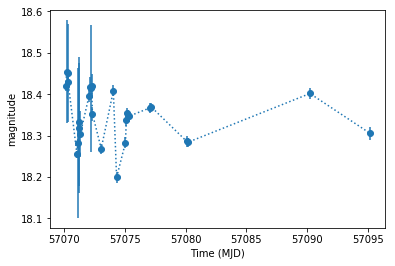

In [38]:
plot_hits(hitsDf.iloc[2])

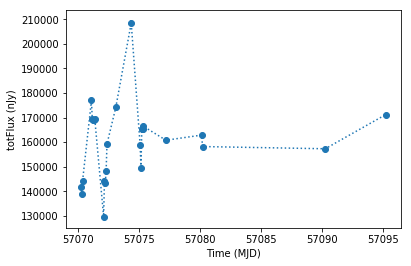

In [39]:
obj = goodObj.iloc[idxRef[2]]['diaObjectId']  # get the LSST DIA Object ID corresponding to one of the 0 - 164 variable objects in the HiTS dataframe
plotLsstLightcurve(obj, dbPath)

## Plotting both light curves on the same plot

In [40]:
# The astropy units module is your friend!
lsstTestMag = (140000*u.nJy).to(u.ABmag)
print(lsstTestMag.value)

18.5346799108044


In [95]:
def plotTwoLightcurves(idx, hitsDf, matchIndices, 
                       dbPath='/epyc/users/mrawls/premap2019/hits-lsst/hits2015/rerun/highres1/association.db',
                       lcPath='/epyc/users/mrawls/premap2019/hits-dr1/light_curves',
                       plotSourceCatLightCurve=False,
                       NSources=10):
    '''Plot a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database), and plot the light curve
    for the same object as measured by the HiTS data release.
    
    Parameters
    ----------
    idx : integer
        specify which of 0-164 HiTS DR1 variables you would like to plot
    hitsDf : Pandas Dataframe containing containing variable objects (HiTS) info
    matchIndices : list or array of integers
        the indices are for lsstCoords corresponding to hitsCoords 0, 1, 2, ... 

    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`
    lcPath : Path on disk to light curves from HiTS DR1
    plotSourceCatLightCurve : boolean, try retrieving source catalog fluxes from LSST for comparison?
        default is False, this is slow but more accurate than forced photometry

    '''
    # Check and see if there are more than NSources comprising the Object, and decide whether to plot it or not
    if goodObj.iloc[matchIndices[idx]]['nDiaSources'] < NSources:
        print(f'Skipping HiTS index {idx} (LSST index {matchIndices[idx]}), fewer than {NSources} DIA Sources in the LSST DIA Object')
        return

    # Use the match index to retrieve the DIA Object ID
    obj = goodObj.iloc[matchIndices[idx]]['diaObjectId']
        
    # Load all sources for this object only
    connection = sqlite3.connect(dbPath)
    forcedSrcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, psFlux, psFluxErr, totFlux, totFluxErr \
                                       from DiaForcedSource where diaObjectId = {obj};', connection)
    srcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, ccdVisitId, psFlux, psFluxErr, totFlux, totFluxErr \
                                 from DiaSource where diaObjectId = {obj};', connection)

    # Convert flux to magnitude
    mags = (np.array(forcedSrcTable['totFlux'])*u.nJy).to(u.ABmag)
    magErrs = 1.0857 / forcedSrcTable['totFluxErr'] / forcedSrcTable['totFlux']
    forcedSrcTable['mags'] = mags
    forcedSrcTable['magErrs'] = magErrs
    
    mags = (np.array(srcTable['totFlux'])*u.nJy).to(u.ABmag)
    magErrs = 1.0857 / srcTable['totFluxErr'] / srcTable['totFlux']
    srcTable['mags'] = mags
    srcTable['magErrs'] = magErrs
    
    plt.figure(figsize=(10,4))
    
    # Retrieve the correct row from the HiTS DR1 dataframe for plotting
    # Use the information in that row to retrieve a HiTS light curve file
    hitsRow = hitsDf.iloc[idx]
    tok = hitsRow['internalID'].split('_')
    field = '_'.join([tok[0], tok[1]])
    ccd = tok[2]
    lightcurveFile = field + '_' + ccd + '_LC_50.tar.gz'
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(hitsRow['internalID'] + '_g.dat')
    dfl = pd.read_csv(data, sep='\t')  # load a file with light curve data into a pandas dataframe
    
    # Get some fun classification info about the object from HiTS
    predicted_class = hitsRow['Predicted_class'].strip()
    class_probability = hitsRow[f"{predicted_class}_Prob"]
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIASource position)
    #plt.errorbar(srcTable['midPointTai'], srcTable['mags'], 
    #             yerr=srcTable['magErrs'], ls=':', marker='o', label='LSST Source', color='C0')
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIAObject position)
    plt.errorbar(forcedSrcTable['midPointTai'], forcedSrcTable['mags'], 
                 yerr=forcedSrcTable['magErrs'], ls=':', marker='o', label='LSST', color='C0')
    
    # Plot the LSST light curve directly from source catalogs
    if plotSourceCatLightCurve:
        objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources \
                              from DiaObject where validityEnd is NULL;', connection)
        sourceCatTimes, sourceCatMags, sourceCatMagErrs = getSourceCatLightCurve(obj, objTable, srcTable, butler)
        plt.errorbar(sourceCatTimes, sourceCatMags, yerr=sourceCatMagErrs, ls=':', marker='o', label='LSST SourceCat', color='C2')
    
    # Plot the HiTS light curve
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', ls=':', label='HiTS', color='C3')

    # Add some plot labels, and reverse the y-axis so bright stuff is at the top
    plt.gca().invert_yaxis()
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')
    #plt.title(f"HiTS index: {idx} | LSST index: {matchIndices[idx]} | {predicted_class} Probability: {class_probability:0.2f}")
    plt.title(f"HiTS classification: {predicted_class} | Probability: {class_probability:0.2f}")
    plt.legend(frameon=False, prop={'size': 16})

In [91]:
def getSourceCatLightCurve(obj, objTable, srcTable, butler):
    '''Retrieve source catalog flux for a DIA Object.
    
    Parameters
    ----------
    obj : DIA Object ID
    objTable : DIA Object table containing one row for object "obj", as a Pandas Dataframe
    srcTable : DIA Source table containing sources associated into "obj", as a Pandas Dataframe
    butler : LSST Science Pipelines Butler instance, for accessing source catalog data
    
    Returns
    -------
    sourceCatTimes : list of times for "obj"
    sourceCatMags : list of magnitudes for "obj"
    sourceCatMagErrs : list of magnitude errors for "obj"
    '''
    skyCoordObj = SkyCoord(objTable['ra'], objTable['decl'], unit=u.deg)
    sourceCatTimes = []
    sourceCatMags = []
    sourceCatMagErrs = []
    for visit in srcTable['ccdVisitId']: 
        dataId = {'visit': int(str(visit)[0:6]), 'ccdnum': int(str(visit)[6:])}
        visit_info = butler.get('calexp_visitInfo', dataId=dataId)
        time = visit_info.getDate().get(system=DateTime.MJD)
        sourceCatTimes.append(time)
        photoCalib = butler.get('calexp_photoCalib', dataId=dataId)
        calsrc = butler.get('src', dataId=dataId)  # this is the full source catalog for that visitID
        calsrcAstropy = calsrc.asAstropy()
        # Find the single source that matches most closely with our object RA and Dec
        calsrcSkyCoord = SkyCoord(calsrcAstropy['coord_ra'], calsrcAstropy['coord_dec'], unit=u.rad)
        matchIdx, matchAngle, match3d = skyCoordObj.match_to_catalog_sky(calsrcSkyCoord)
        calibMag = photoCalib.instFluxToMagnitude(calsrc, 'base_PsfFlux')[matchIdx]
        sourceCatMags.append(calibMag[0,0])
        sourceCatMagErrs.append(calibMag[0,1])
    
    return sourceCatTimes, sourceCatMags, sourceCatMagErrs

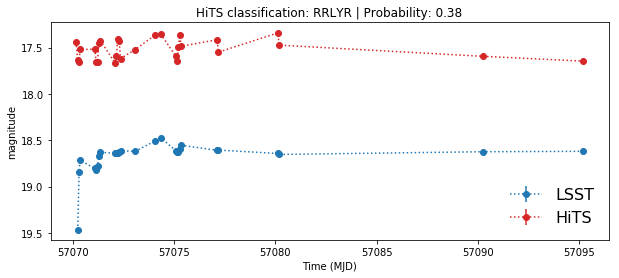

In [120]:
plotTwoLightcurves(109, hitsDf=hitsDf, matchIndices=idxRef, plotSourceCatLightCurve=False, NSources=1)  # 88 109 97

Skipping HiTS index 0 (LSST index 23275), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 1 (LSST index 13946), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 3 (LSST index 11859), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 5 (LSST index 7466), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 6 (LSST index 22264), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 7 (LSST index 30986), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 8 (LSST index 35177), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 9 (LSST index 17819), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 10 (LSST index 35180), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 12 (LSST index 14858), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 14 (LSST index 19642), fewer than 10 DIA Sources in the LSST DIA Obje

/epyc/users/mrawls/lsst_stack/python/miniconda3-4.5.12/envs/lsst-scipipe-f032070/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Skipping HiTS index 70 (LSST index 8892), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 71 (LSST index 19108), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 73 (LSST index 10643), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 74 (LSST index 15201), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 77 (LSST index 18239), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 79 (LSST index 25797), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 80 (LSST index 19007), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 81 (LSST index 17005), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 82 (LSST index 4937), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 83 (LSST index 35334), fewer than 10 DIA Sources in the LSST DIA Object
Skipping HiTS index 86 (LSST index 8362), fewer than 10 DIA Sources in the LSST DI

FileNotFoundError: [Errno 2] No such file or directory: '/epyc/users/mrawls/premap2019/hits-dr1/light_curves/Blind14A_10/N13/Blind14A_10_N13_LC_50.tar.gz'

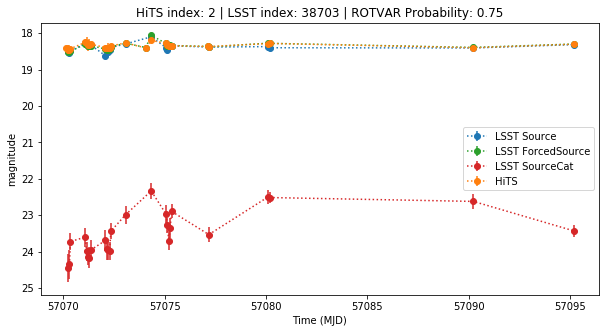

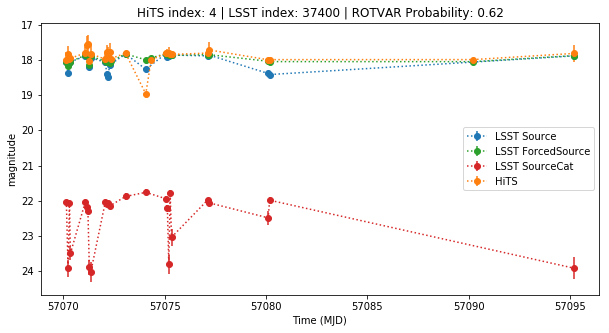

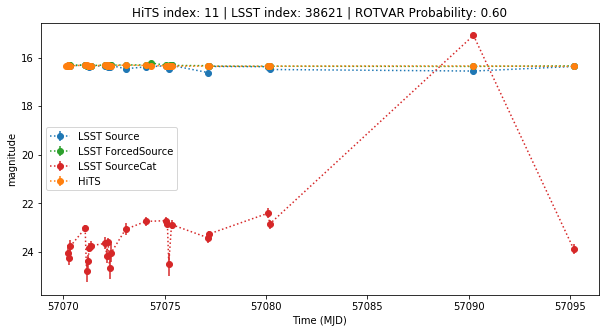

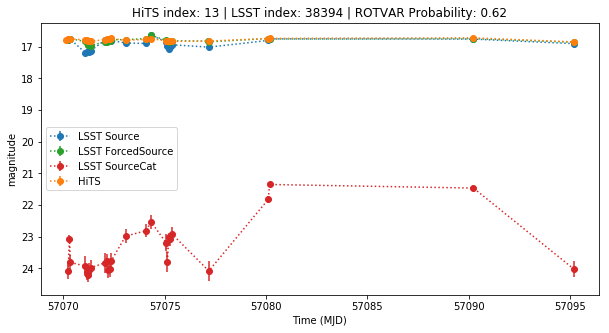

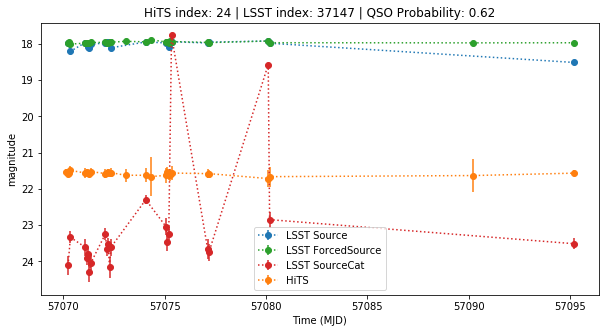

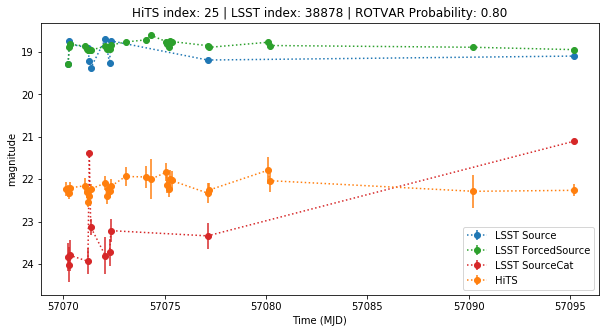

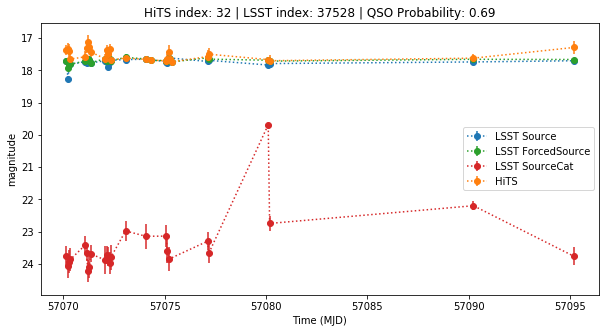

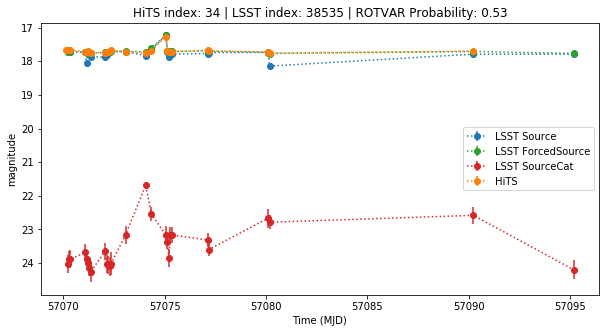

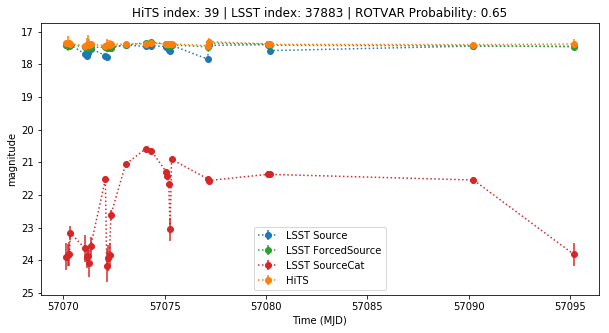

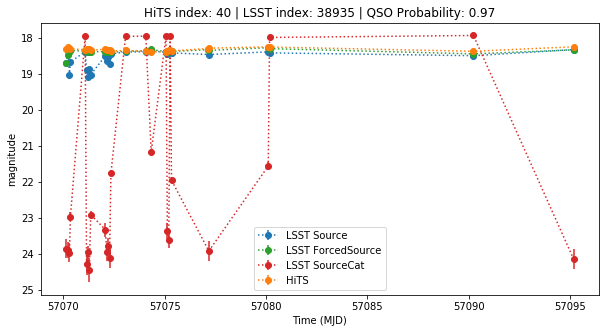

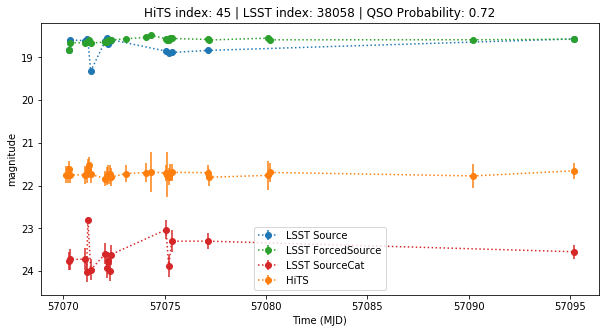

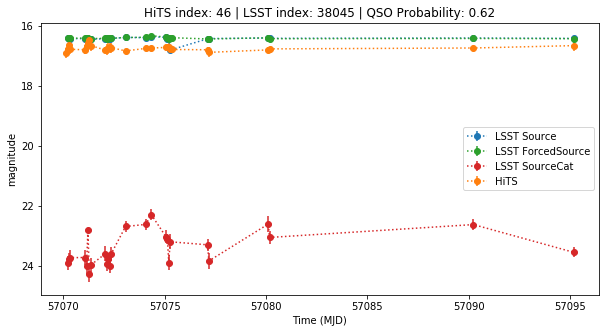

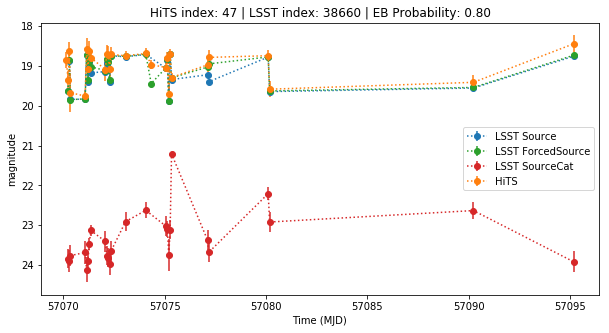

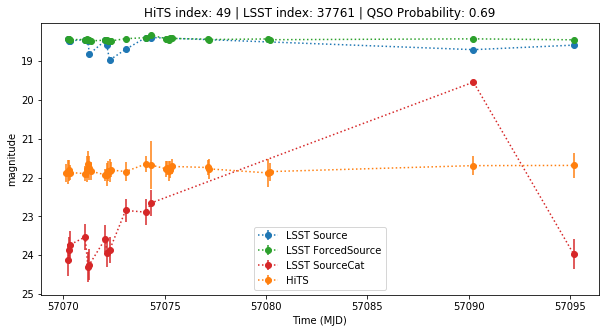

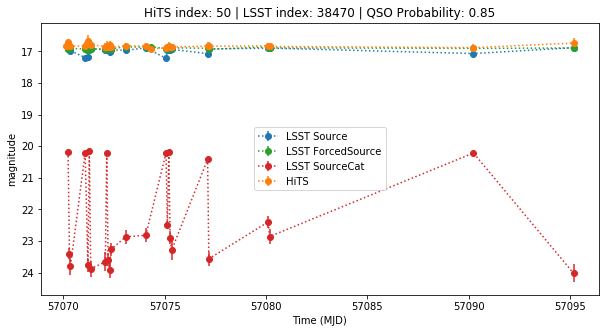

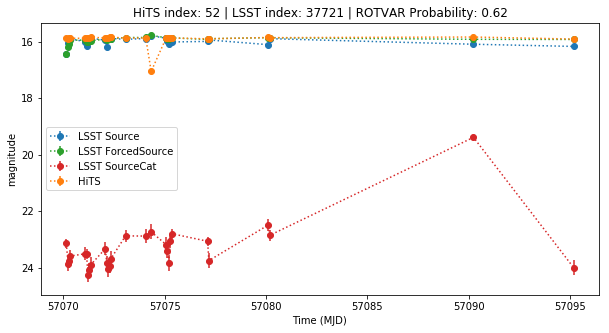

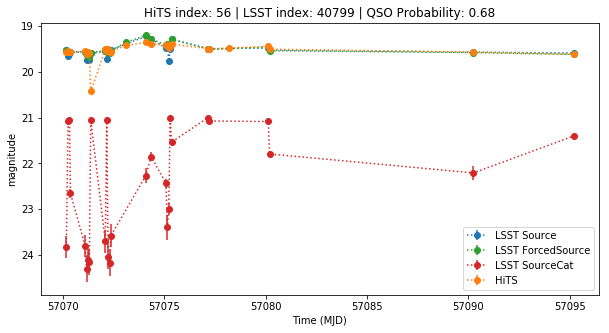

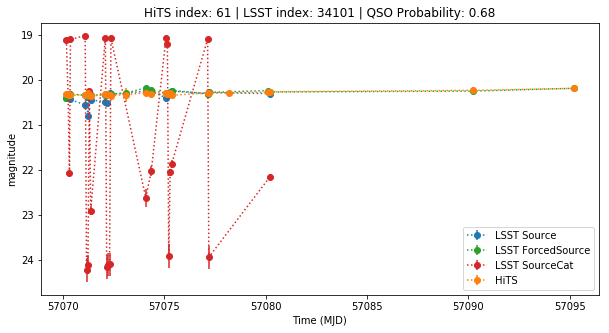

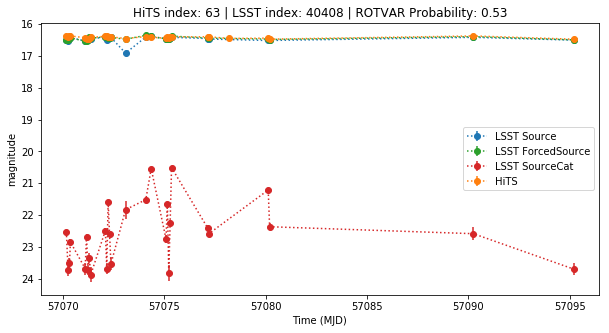

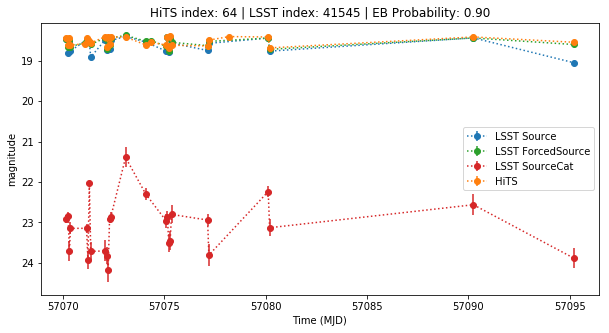

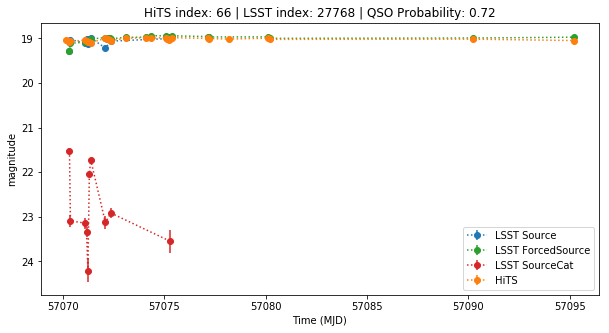

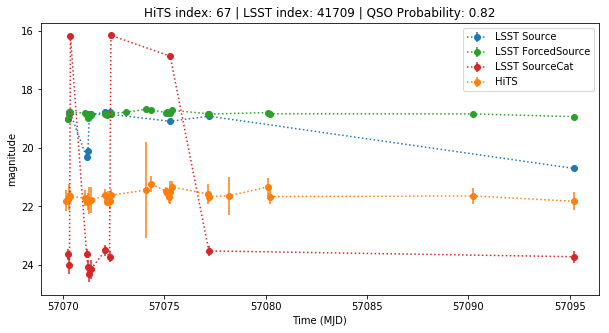

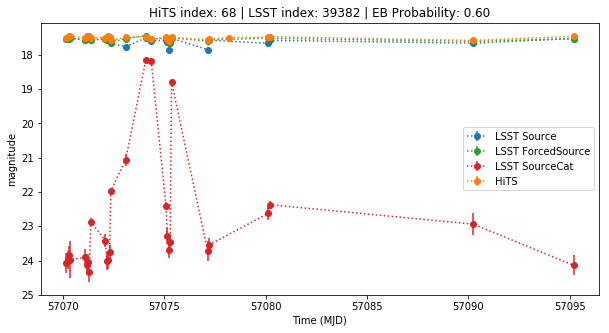

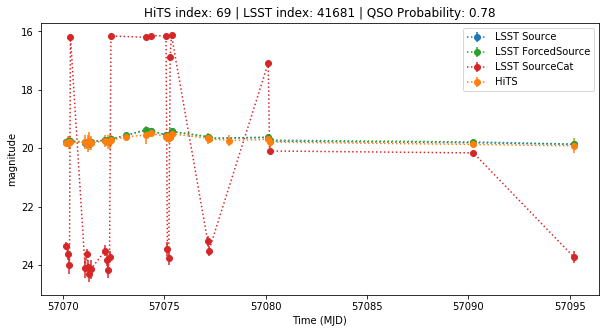

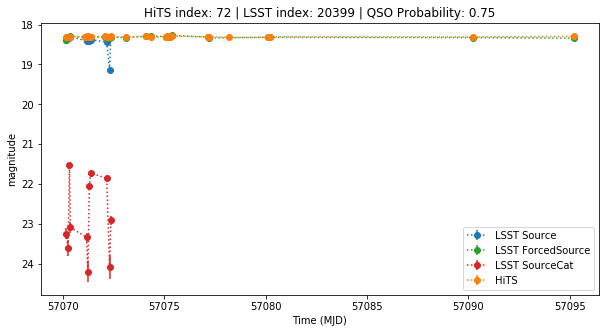

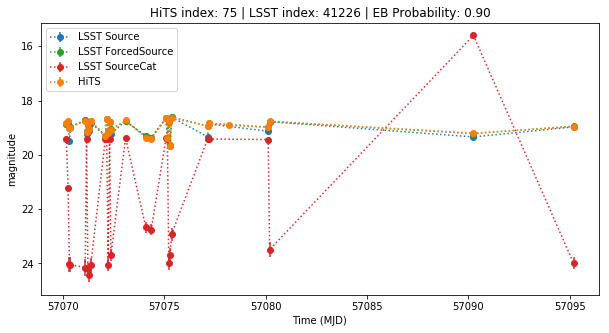

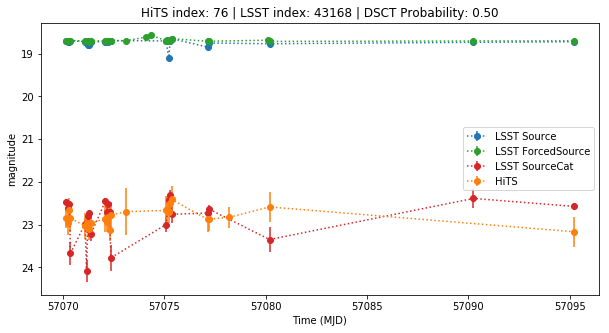

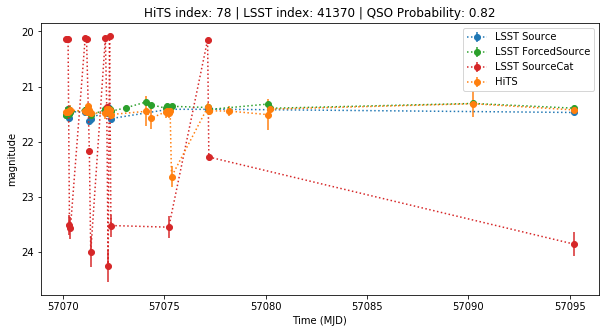

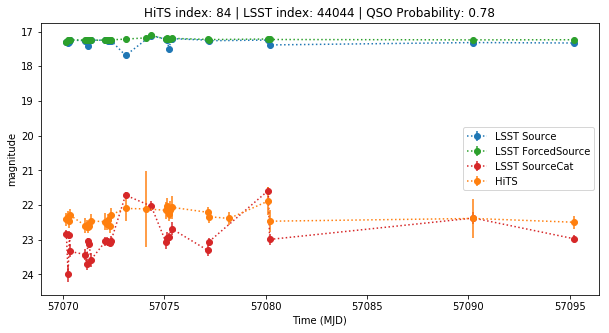

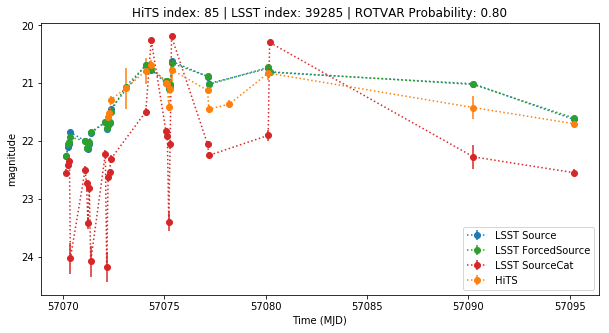

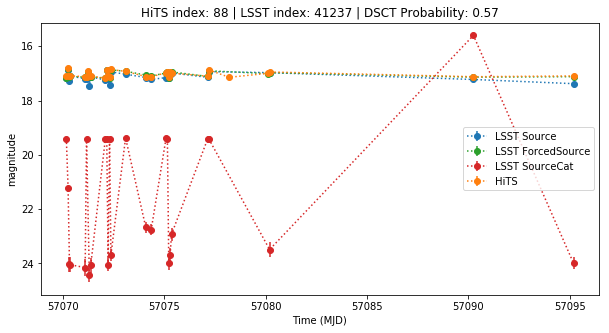

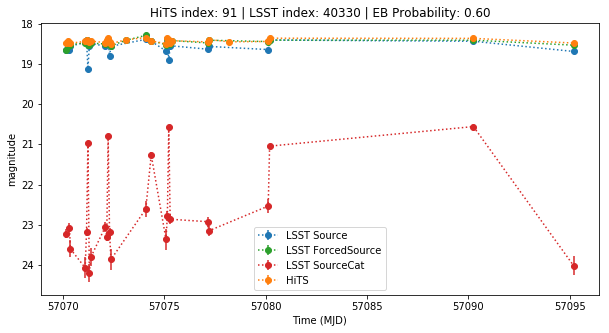

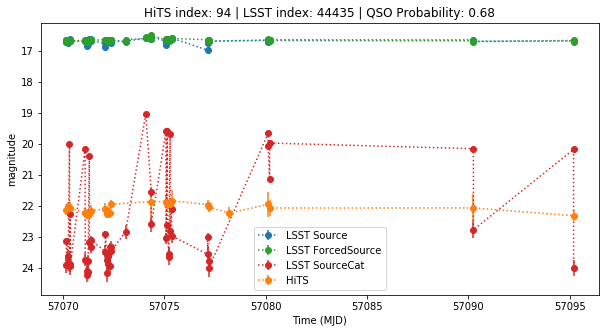

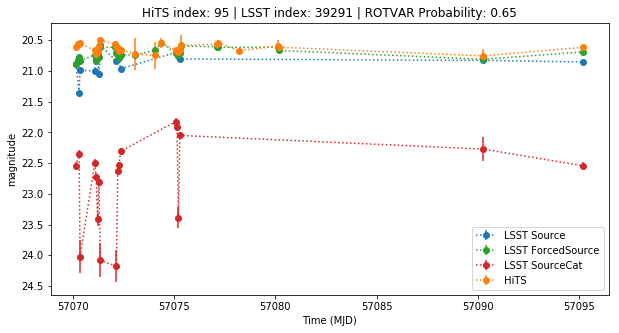

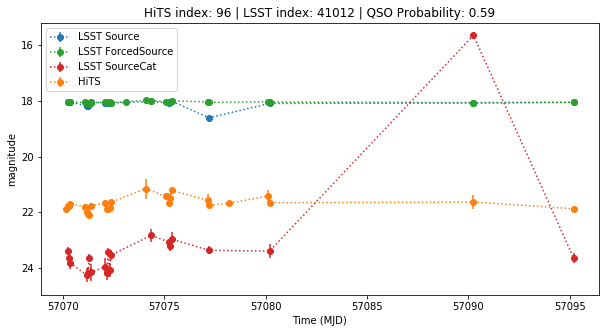

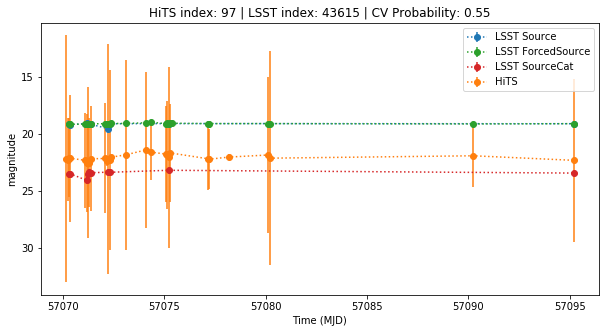

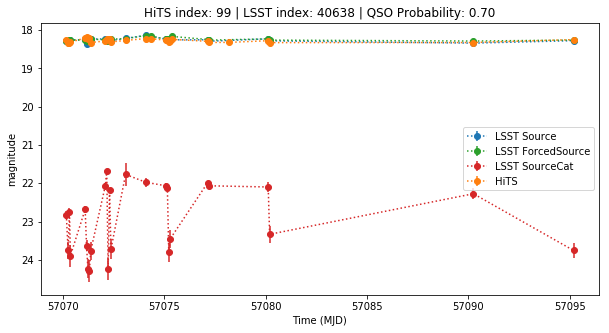

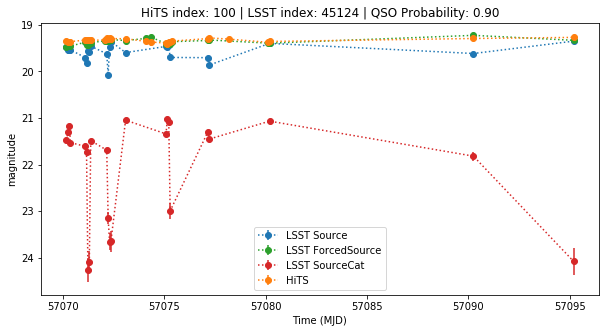

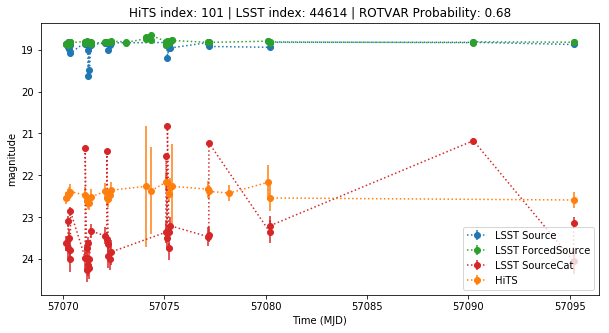

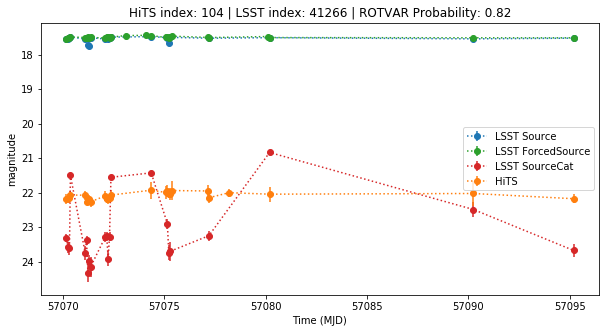

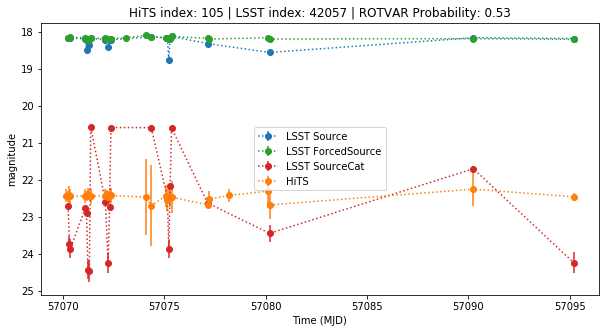

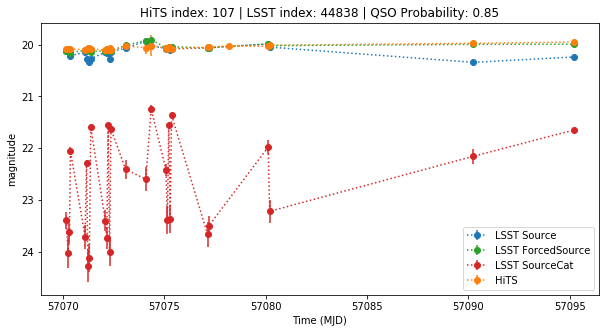

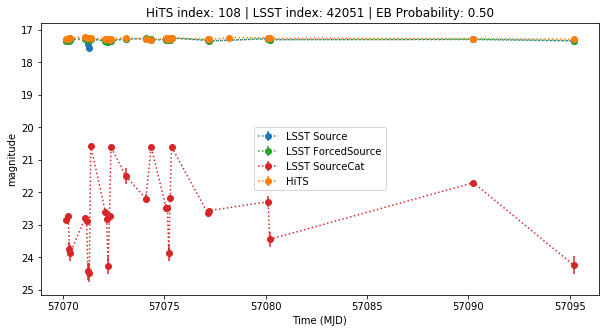

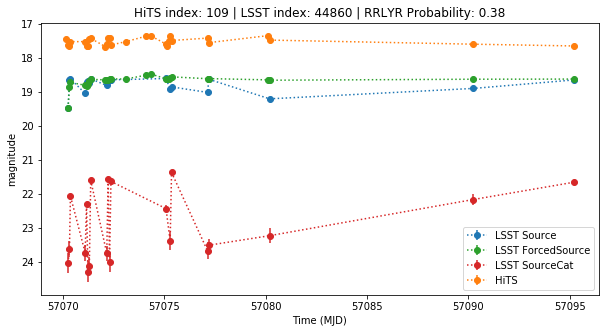

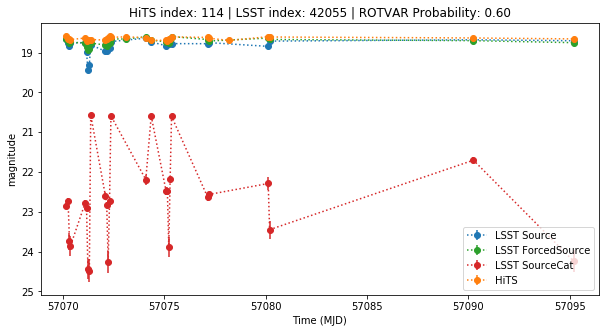

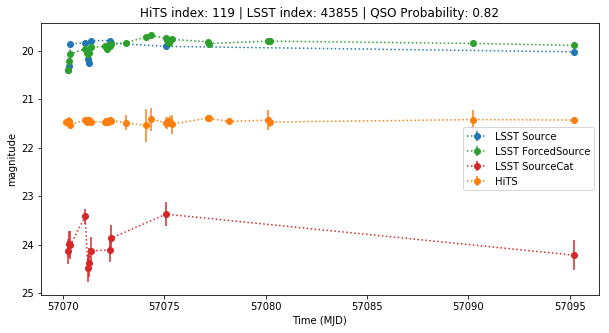

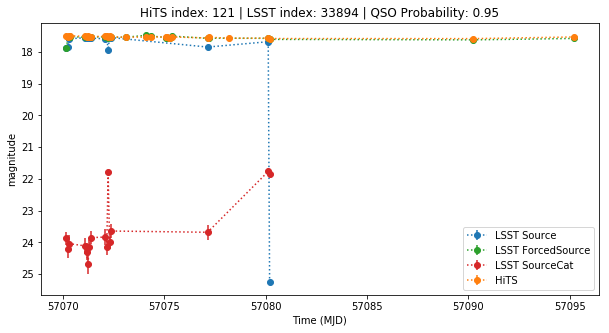

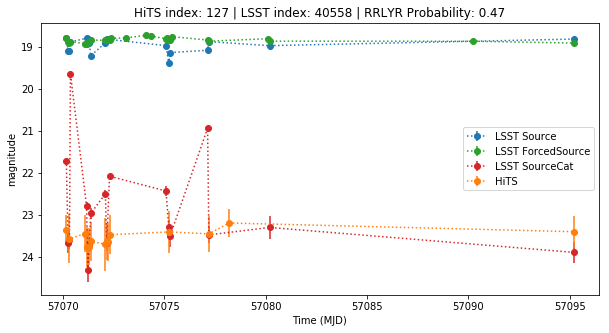

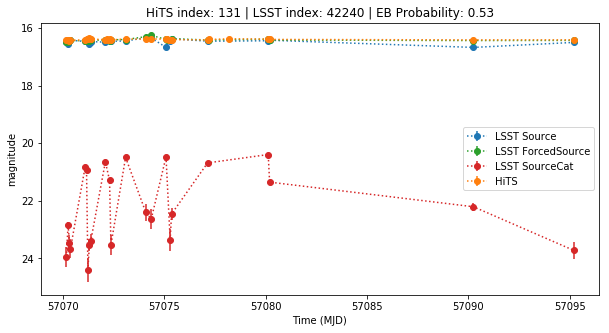

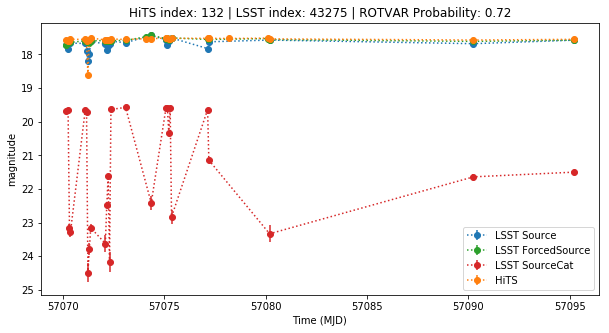

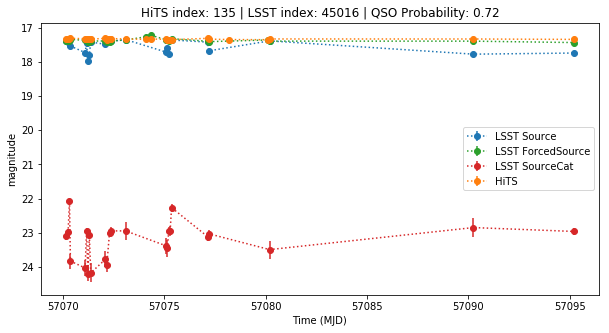

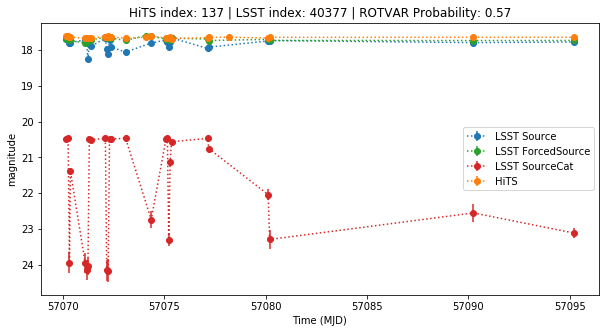

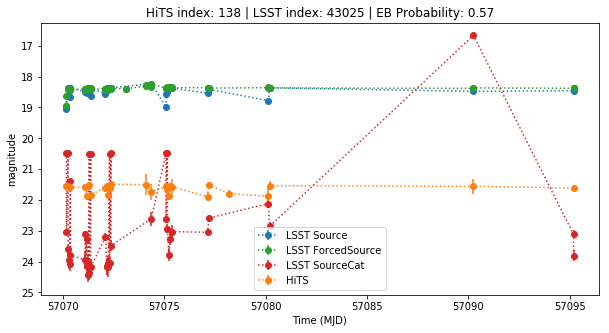

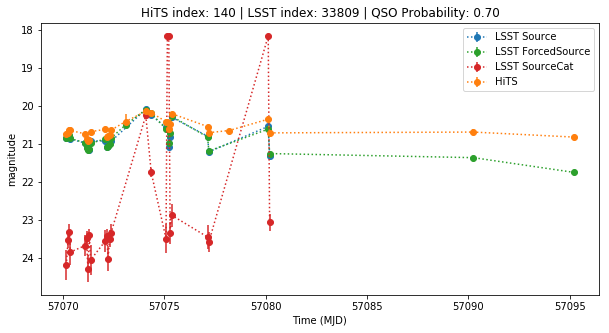

<Figure size 720x360 with 0 Axes>

In [55]:
for i in range(0, len(idx)):
    plotTwoLightcurves(i, hitsDf=hitsDf, matchIndices=idxRef, plotSourceCatLightCurve=True)

Uhhhhh OK so I have some questions about what is going on. Very briefly...
* "LSST Source" (blue) is the magnitude on the processed image (not the difference image) at the position of the Source. There will only be points where a given visit has a detected Source in the difference image.
* "LSST Forced Source" (green) is the magnitude on the processed image at the position of the Object. The Object position is the average of all the Source positions. There will be a point whether or not there is a detected Source in any given visit's difference image. I expect green to mostly be on top of blue with just some small discrepencies, and so it is.
* "LSST SourceCat" (red) is the magnitude on the processed image from before any difference imaging (or source detection on said difference image) happened. There will only be a point there if there is a detected Source in the processed image.
* I included the kind of variable source (and the probability of it being that) as the title of each plot. The probabilities go from 0 (lol nope) to 1 (definitely).

I am not sure why there are **systematic offsets** between different kinds of magnitudes. I'm pretty sure all of the magnitudes were computed from fluxes correctly. It is especially weird to me that sometimes everything lines up and sometimes it doesn't (see, e.g., object index 2, where everything **except** the source catalog flux is roughly in the same place).

* Make a new plot of the objects on the sky, using only the no-bad-flag ones (the `goodObj` dataframe). Overplot the HiTS objects and try color-coding them by variability class!

Meredith blatantly stole this working code from Thomas, thank you :)

In [62]:
ax1Filter = (goodObj['decl'] > -2)# & (goodObj['nDiaSources'] > 10)
ax2Filter=(goodObj['decl'] <= -2)# & (goodObj['nDiaSources'] > 10)

ra1_first=goodObj.loc[ax1Filter, 'ra']
dec1_first=goodObj.loc[ax1Filter, 'decl']
ra2_first=goodObj.loc[ax2Filter, 'ra']
dec2_first=goodObj.loc[ax2Filter, 'decl']

ax1Filter_second = (hitsDf['decMedian'] > -2)
ax2Filter_second = (~ax1Filter_second)

ra1_second=hitsDf.loc[ax1Filter_second, 'raMedian']
dec1_second=hitsDf.loc[ax1Filter_second, 'decMedian']
ra2_second=hitsDf.loc[ax2Filter_second, 'raMedian']
dec2_second=hitsDf.loc[ax2Filter_second, 'decMedian']

In [72]:
def plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second):
    """This function takes two sets of RA and Dec and plots them
    both on the sky in different colors.
    
    It is customized to plot a specific region (three HiTS fields in two panels).
    
    "1" and "2" refer to the two panels in the plot.
    "first" and "second" refer to the two different datasets.
    """
    # Set up the figure object and two axes
    fig = plt.figure(figsize=(16, 12))
    ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)
    ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)

    # Plot the first set of RAs and Decs in blue
    # This will be from the LSST database
    ax1.scatter(ra1_first, dec1_first, marker='.', s=2, alpha=0.5, c='C0',label='LSST')
    ax2.scatter(ra2_first, dec2_first, marker='.', s=2, alpha=0.5, c='C0',label='LSST')
    
    # Plot the second set of RAs and Decs in red
    # This will be from the HiTS DR1
    ax1.scatter(ra1_second, dec1_second, marker='.', s=60, alpha=0.5, c='red',label='HiTS')
    ax2.scatter(ra2_second, dec2_second, marker='.', s=60, alpha=0.5, c='red',label='HiTS')

    #plt.title('View of Objects from LSST and HiTS on the Sky', fontsize=15.5)
    
    ax1.tick_params(axis='both', which='major', labelsize=11.5)
    ax1.tick_params(axis='both', which='minor', labelsize=11.5)

    ax2.tick_params(axis='both', which='major', labelsize=11.5)
    ax2.tick_params(axis='both', which='minor', labelsize=11.5)
    
    #lgnd = ax1.legend(loc="lower left", scatterpoints=1, fontsize=10, prop={'size': 11.5}, frameon=False)
    #lgnd.legendHandles[0]._sizes = [60]
    #lgnd.legendHandles[1]._sizes = [60]
    
    lgnd2 = ax2.legend(loc="center right", scatterpoints=1, fontsize=10, prop={'size': 11.5}, frameon=False)
    lgnd2.legendHandles[0]._sizes = [60]
    lgnd2.legendHandles[1]._sizes = [60]
    
    ax1.set_xlabel('RA (deg)')
    ax2.set_xlabel('RA (deg)')
    ax1.set_ylabel('Dec (deg)')
    ax2.set_ylabel('Dec (deg)')

    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.invert_xaxis()
    ax2.invert_xaxis()

    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position('right')

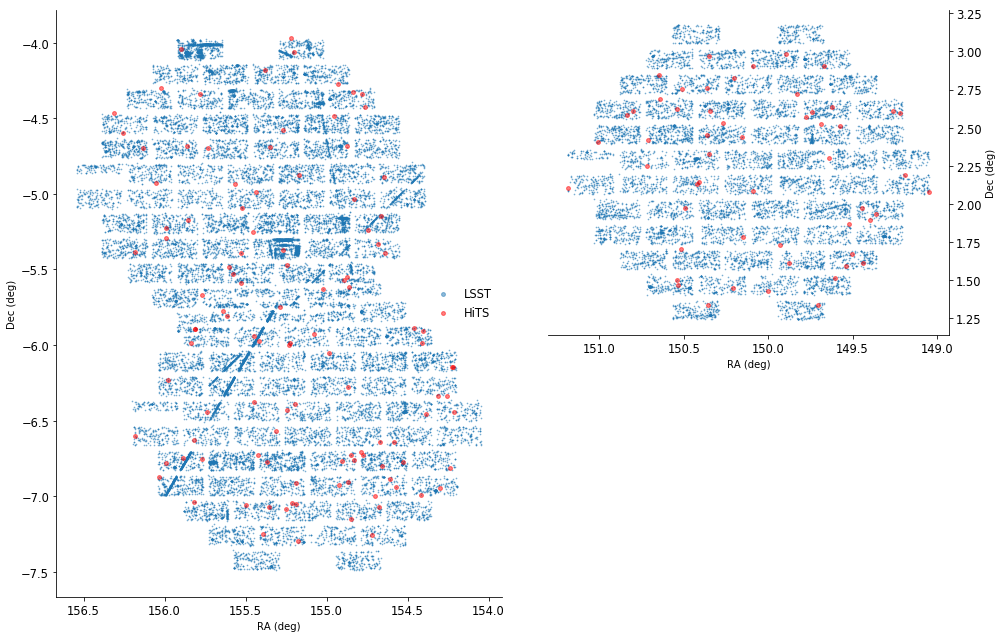

In [73]:
plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second)